## 02. Using the GALACTICNUCLEUS catalog

This script aims to simulate a spectral image that would be observed using slitless spectroscopy, using the data on the star position and flux as was obtained from the GALACTICNUCLEUS survey. The original publication can be found [here](https://www.aanda.org/articles/aa/full_html/2019/11/aa36263-19/aa36263-19.html#S2) and the data can also be downloaded from [here](http://cdsarc.unistra.fr/viz-bin/cat/J/A+A/631/A20). 

Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Francisco Nogueras-Lara and Nadine Neumayer (MPIA)** <br/>
Date: **05th October 2020** <br/>

In [4]:
import astropy.io.fits as fits
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.interpolate import interp1d
import numpy as np
import os
import importlib

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

# to show progress during computations
from time import sleep
import sys

import matplotlib

In [5]:
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

**Personal imports** (functions imported can be found in the 'imported_files/' folder)

In [6]:
sys.path.append('imported_files/')
import Simulating_Spectra as ss
import plotting as pt
import Slitless_spec_forward_modelling as ssfm

#### 1. Defining input parameters

In [51]:
# setting up the working directory path
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Data")

# putting together the file name
string_name = 'central_pixels.txt'
filename = os.path.join(data_dir, string_name)

# region of the sky into which we zoom in
de_ll, de_ul = -29.04, -29.06

# variable to select number of stars
max_stars = 1000

# FOV in pixels
l_pix, u_pix = 0, 1000

# cuts off stars below a certain flux from the bottom
cut_off_ll = 15

# wavelength to pixel conversions
delta_lambda = 0.0005  # micro meter ==  1 pixel
k_band_lambda0 = 2.2
r = k_band_lambda0/delta_lambda

k_band_range = 0.3 # micro meter (2.1-2.4 micro meters)
disperse_range = k_band_range/delta_lambda
print('The size of dispersion is set to be %d pixels'%disperse_range)

dispersion_angle = 0 # degrees

# selecting a small region of the sky
limits = [1000, 2000, 2500, 3500]

The size of dispersion is set to be 600 pixels


Star distribution parameters

In [8]:
# Load the 10 random spectra with added LSF, which can be associated with the stars in the FOV.
flux_LSF2D, params = np.load('Data/flux_K2D_LSF_norm.npy'), np.load('Data/params.npy')
waves_k = np.load('Data/waves_k.npy')

# division of stars chosen in FOV, considering 10 temperatures with 10 log g's
stars_divide = [0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9]

# selection cut to select forground star
forground_star_cut = 1.1

#### 2. Selection Procedure

1. Select small region of the sky for the given FOV
2. Select stars whose flux != 99 (implying no star exists in the data set)
3. Select stars whose flux is magnitude is > 50
4. Select only 1000 random stars from the given FOV

In [46]:
importlib.reload(ssfm)
x_pos, y_pos, mag_H, mag_Ks = ssfm.readCatalogFile(filename)

# step 1: defining the FOV to be a few arcmin x arcmin
x_pos, y_pos, mag_H, mag_Ks = ssfm.selectFOV(limits, x_pos, y_pos, mag_H, mag_Ks)

# step 2: make sure data is free of rogue points i.e. flux = 99 points
x_pos, y_pos, mag_H, mag_Ks = ssfm.selectRealStars(x_pos, y_pos, mag_H, mag_Ks)

# step 3: setting lower limit on the flux
x_pos, y_pos, mag_H, mag_Ks = ssfm.cutOffFlux(cut_off_ll, x_pos, y_pos, mag_H, mag_Ks)

# step 4: select a few thousand stars within the FOV
x_pos, y_pos, mag_H, mag_Ks = ssfm.selectMaxStars(max_stars, x_pos, y_pos, mag_H, mag_Ks)

Choosing 0.00 percent stars from 2009522 total stars.
Selecting real stars...
Discarding stars with magnitude > 15.
Selecting a max of 1000 stars in the FOV randomly.


Plotting the selected stars in the chosen FOV.

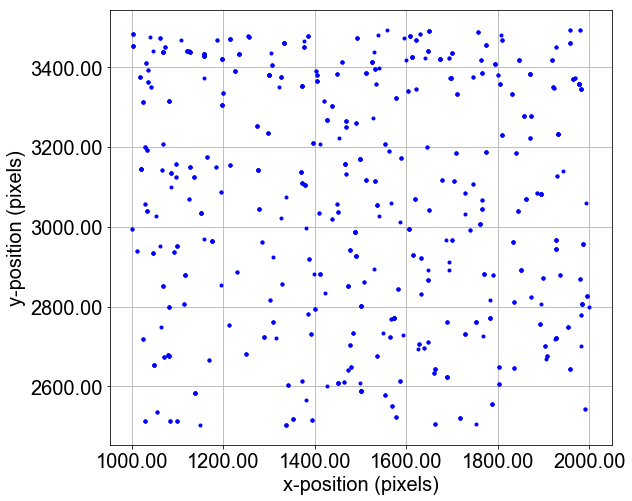

In [47]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

# plotting the stars
ax.plot(x_pos, y_pos, "b.")
pt.setLabel(ax, 'x-position (pixels)', 'y-position (pixels)', '', 'default', 'default', legend=False)

pt.shortenXYaxisTicks(ax)

#### 3. Dispersing the stars

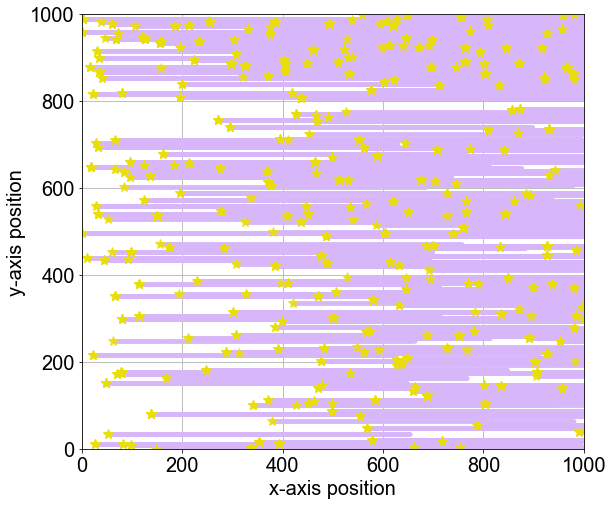

In [52]:
# mapping right ascension and declination to (pixel, pixel) FOV
x_pos, y_pos = ssfm.mapToFOVinPixels(x_pos, y_pos, u_pix)

# dispersing the stars and plotting it
x_disperse, y_disperse = pt.plotDispersedStars(x_pos, y_pos, l_pix, u_pix, \
                                               disperse_range, waves_k, \
                                               dispersion_angle)

Associates the stars with spectra of a certain temperature, log(surface gravity) at redshift, z=0. 

In [53]:
flux_k2D, type_id = ssfm.associateSpectraToStars(waves_k, stars_divide, max_stars, \
                                  flux_LSF2D, params)

flux_k2D = [flux_k2D[i]*mag_Ks[i] for i in range(max_stars)]

100 stars at Teff = 12000 K, log g = 6.0
0 stars at Teff = 11800 K, log g = 2.5
0 stars at Teff = 10000 K, log g = 3.0
0 stars at Teff = 8400 K, log g = 6.0
0 stars at Teff = 7600 K, log g = 3.5
0 stars at Teff = 6900 K, log g = 3.0
0 stars at Teff = 5900 K, log g = 3.0
0 stars at Teff = 5100 K, log g = 2.0
0 stars at Teff = 4700 K, log g = 1.5
900 stars at Teff = 3900 K, log g = 6.0


In [54]:
flux_matrix2D, flux_matrix_stars2D = np.zeros((u_pix, u_pix)), np.zeros((u_pix, u_pix))
flux_matrix2D = ss.construct2DFluxMatrix(flux_matrix2D, y_disperse, x_disperse, \
                                         flux_k2D, u_pix)

flux_matrix_stars2D = csr_matrix((mag_Ks, (y_pos, x_pos)), shape=(u_pix, u_pix)).toarray()

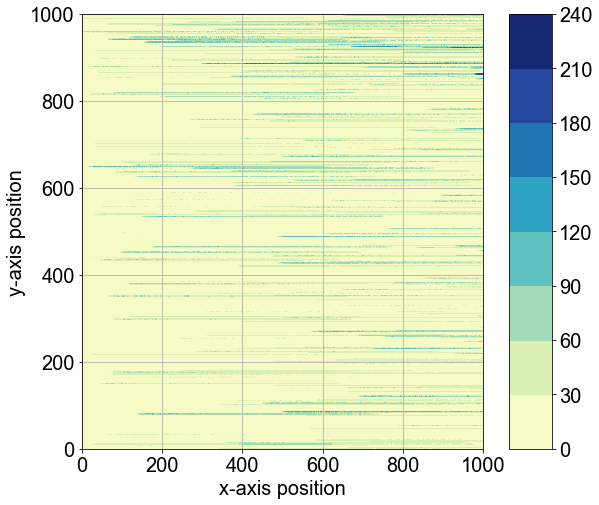

In [55]:
pt.plotContour(l_pix, u_pix, ss.addNoise(flux_matrix2D, u_pix))

#### 4. Estimating forground stars

Forground population of stars in sample (H-K_s < 1.1): 70 stars


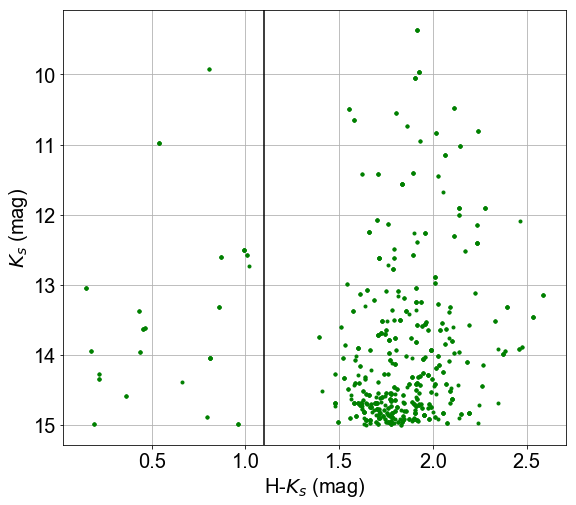

In [65]:
# plot the result
fig, ax = plt.subplots(1,1,figsize=(9,8))
ax.plot(mag_H-mag_Ks, mag_Ks, 'g.')
ax.invert_yaxis()
importlib.reload(ss)
#plot vertical line signifying the cut-off
ax.axvline(forground_star_cut, color='k')
pt.setLabel(ax, r'H-$K_s$ (mag)', r'$K_s$ (mag)', '', 'default', 'default', legend=False)
ss.printForgroundPopulation(mag_H-mag_Ks, max_stars)